In [1]:
import os
from os import path
import pandas as pd
import hashlib
import gzip
import tempfile
from sklearn.preprocessing import LabelEncoder
from picrust2.wrap_hsp import (castor_hsp_workflow,
                               castor_nsti)
from sklearn import metrics
from sklearn.model_selection import LeaveOneOut

import numpy as np
from skbio import TreeNode
from io import StringIO
from pathlib import Path

In [2]:
#bacdiev data
discdf = pd.read_table('../data/bacdive-data/gg-mapped-tree-data/bacdive-binary-matched.tsv',
                          index_col=0,low_memory=False)
discdf = discdf.reset_index().drop_duplicates(subset='index', keep='first').set_index('index')
discdf.index = discdf.index.astype(str)
keep_cols = [col_ for col_ in discdf.columns 
             if discdf.dropna(subset=[col_]).shape[0] > 100]
discdf = discdf[['Spore']]
# need to set the comp to false
sing_val_col = [col_ for col_ in discdf.columns
                if len(set(discdf.dropna(subset=[col_])[col_])) == 1]
discdf[sing_val_col] = discdf[sing_val_col].fillna(value=False)
# get tree and match
in_tree='../data/bacdive-data/gg-mapped-tree-data/99-otus-unannotated.tree'
tree = TreeNode.read(StringIO(Path(in_tree).read_text()))
tree_matched = list(set([node.name for node in tree.tips()])&set(discdf.index))
discdf = discdf.reindex(index=tree_matched)
discdf.shape


(9004, 1)

In [4]:
# column to learn
res_cont = {}
res_cont_all = {}
discdf_bools = discdf.copy()
# we just want to benchmark sporulation
for sub_col in ['Spore']:

    # sub set table
    discdf_subset = discdf_bools.copy()
    discdf_subset.index.name = 'assembly'
    discdf_subset = pd.DataFrame(discdf_subset[sub_col].dropna())
    enc = LabelEncoder().fit(discdf_subset[sub_col])
    discdf_subset[sub_col] = enc.transform(discdf_subset[sub_col]).astype(int)
    discdf_subset = pd.DataFrame(pd.to_numeric(discdf_subset[sub_col]))

    # sub set the tree to only knowns
    tree_subset = tree.copy()
    tree_subset = tree_subset.shear(list(discdf_subset.index))

    # build LOO
    loo = LeaveOneOut()
    loo.get_n_splits(discdf_subset)

    # run LOO
    ytests = []
    ypreds = []
    for train_index, test_index in loo.split(discdf_subset):
        # subset to learn
        discdf_subset_loo = discdf_subset.iloc[train_index, :]
        # generate the temp. directory to store res
        with tempfile.TemporaryDirectory() as temp_dir_name:
            # save tree to a tmp dir
            tree_tmp = os.path.join(temp_dir_name, 'phylogeny_desc.tree')
            tree_subset.write(tree_tmp)
            # save traits to a tmp dir
            traits_tmp = os.path.join(temp_dir_name, 'traits_desc.tsv')
            discdf_subset_loo.to_csv(traits_tmp, sep='\t')
            # run castor
            hsp_method='emp_prob'
            predict_out, ci_out = castor_hsp_workflow(tree_path=tree_tmp,
                                                      trait_table_path=traits_tmp,
                                                      hsp_method=hsp_method)
        # save test and pred.
        ytests.append(discdf_subset.iloc[test_index, :].values[0][0])
        ypreds.append(predict_out.values[0][0])

    # eval.
    res_cont_all[(sub_col,'real')] = ytests
    res_cont_all[(sub_col,'predicted')] = ypreds
    # evals
    res_cont[(sub_col,'R2')] = [metrics.r2_score(ytests,
                                                 ypreds)**2]
    res_cont[(sub_col,'MSE')] = [metrics.mean_squared_error(ytests,
                                                            ypreds)]


In [5]:
pd.DataFrame(res_cont).columns

MultiIndex([('Spore',  'R2'),
            ('Spore', 'MSE')],
           )

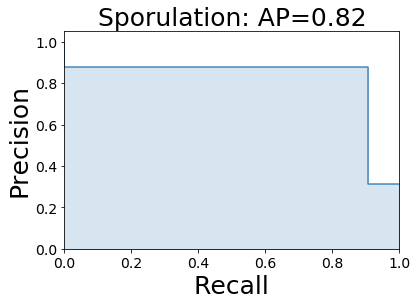

In [9]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from inspect import signature

#plot
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.colors import to_hex
import seaborn as sns

plt.rcParams["axes.titlesize"] = 25
plt.rcParams["axes.labelsize"] = 25
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
    
%matplotlib inline

lbls_ = {'Motile':'Motility','Spore':'Sporulation',
         'Animal_Pathogen':'Animal Pathogen',
               'Human_Pathogen':'Human Pathogen',
               'Plant_Pathogen':'Plant Pathogen'}

for pheno_ in ['Spore']:
  
    y_test = res_cont_all[(pheno_, 'real')].copy()
    y_score = res_cont_all[(pheno_, 'predicted')].copy()
    average_precision = average_precision_score(y_test, y_score)
    precision, recall, _ = precision_recall_curve(y_test, y_score)

    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision, color='#377eb8', alpha=0.9,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='#377eb8', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    #plt.title('2-class Precision-Recall curve'%(average_precision),
    #          fontsize=14,y=.9)
    plt.title(lbls_[pheno_]+': AP=%0.2f'%(average_precision),fontsize=25,y=1.0)
    
    # save the figure to file
    plt.savefig('../results/figures/LOO-bench-spore.pdf',
                dpi=600, 
                bbox_inches='tight',
                edgecolor='none')


    plt.show()